In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.compose import make_column_transformer

from tensorflow.keras import layers
from tensorflow import keras

import xgboost as xgb

import shap

## Load Data
The files are organised in the respective mode and time of the day, using many JSON files.
It is helpful to use glob here to index all of them quickly.

In [2]:
path_central_novice = r'C:\Users\imnku\Documents\Data Analysis\AMQ\CentralR-N'
all_files_central_novice = glob.glob(os.path.join(path_central_novice, "*.json"))

central_novice = pd.concat((pd.read_json(f) for f in all_files_central_novice), ignore_index=True)

path_east_novice = r'C:\Users\imnku\Documents\Data Analysis\AMQ\EastR-N'
all_files_east_novice = glob.glob(os.path.join(path_east_novice, "*.json"))

east_novice = pd.concat((pd.read_json(f) for f in all_files_east_novice), ignore_index=True)

path_east_expert = r'C:\Users\imnku\Documents\Data Analysis\AMQ\EastR-E'
all_files_east_expert = glob.glob(os.path.join(path_east_expert, "*.json"))

east_expert = pd.concat((pd.read_json(f) for f in all_files_east_expert), ignore_index=True)

path_central_expert = r'C:\Users\imnku\Documents\Data Analysis\AMQ\CentralR-E'
all_files_central_expert = glob.glob(os.path.join(path_central_expert, "*.json"))

central_expert = pd.concat((pd.read_json(f) for f in all_files_central_expert), ignore_index=True)

expert = pd.concat(([central_expert, east_expert]), ignore_index=True)
novice = pd.concat(([central_novice, east_novice]), ignore_index=True)
both = pd.concat(([novice, expert]), ignore_index=True)
both.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7435 entries, 0 to 7434
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gameMode       7435 non-null   object 
 1   name           7435 non-null   object 
 2   artist         7435 non-null   object 
 3   anime          7435 non-null   object 
 4   annId          7435 non-null   int64  
 5   songNumber     7435 non-null   int64  
 6   activePlayers  7435 non-null   int64  
 7   totalPlayers   7435 non-null   int64  
 8   type           7435 non-null   object 
 9   urls           7435 non-null   object 
 10  siteIds        7435 non-null   object 
 11  difficulty     7435 non-null   object 
 12  animeType      7435 non-null   object 
 13  animeScore     7435 non-null   float64
 14  vintage        7435 non-null   object 
 15  tags           7435 non-null   object 
 16  genre          7435 non-null   object 
 17  altAnswers     7435 non-null   object 
 18  startSam

## Data cleaning & feature engineering
We drop:
- The site indentifier(s) and URLs: too specific.
- ANN anime score: broken statistic, though would be nice if to use if it was not.
- Gamemode: always ranked.
- Own answer: only useful for us.
- From whose list the anime is: lists are off in ranked.

Create:
- We remove the number from type of song (too many).
- We use the only the year.
- Normalise the sample point of where the song plays.

In [4]:
novice = both.copy()

In [5]:
novice['correct'] = novice['correct'].astype(np.bool_)
X = novice.drop(['annId', 'urls', 'siteIds', 'animeScore', 'altAnswers', 'fromList', 'gameMode', 'selfAnswer'], axis=1).copy()
X = X.dropna()
X = X.loc[~(X['difficulty'] == 'Unrated')]
X = X.astype({'difficulty': float})
y = X.pop('correct')

X['samplePercent'] = X['startSample']/X['videoLength']
X['type_noNumber'] = X['type'].str.split().str[0]
X['AiredYear'] = X['vintage'].str.split().str[1].astype(int)

X = X.drop(['name', 'artist', 'anime', 'songNumber', 'activePlayers', 'totalPlayers', 'type', 'vintage',
            'startSample', 'videoLength', 'players'], axis=1)

print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7378 entries, 0 to 7389
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   difficulty     7378 non-null   float64
 1   animeType      7378 non-null   object 
 2   tags           7378 non-null   object 
 3   genre          7378 non-null   object 
 4   samplePercent  7378 non-null   float64
 5   type_noNumber  7378 non-null   object 
 6   AiredYear      7378 non-null   int32  
dtypes: float64(2), int32(1), object(4)
memory usage: 432.3+ KB
None
<class 'pandas.core.series.Series'>
Int64Index: 7378 entries, 0 to 7389
Series name: correct
Non-Null Count  Dtype
--------------  -----
7378 non-null   bool 
dtypes: bool(1)
memory usage: 64.8 KB
None


## Data preprocessing

In [6]:
data_list = ['tags', 'genre']
data_num = ['difficulty', 'samplePercent', 'AiredYear']
data_cat = ['animeType', 'type_noNumber']

mlb = MultiLabelBinarizer()
s = X['tags']
dummy = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=X.index)
X = pd.concat([X, dummy], axis=1)

s = X['genre']
dummy = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=X.index)
X = pd.concat([X, dummy], axis=1)

X = X.drop(['tags', 'genre'], axis=1)

X = pd.get_dummies(X, columns=data_cat)
"""
scaler = StandardScaler()
s = X[data_num]
dummy = pd.DataFrame(scaler.fit_transform(s), columns=s.columns, index=X.index)
X = X.drop(data_num, axis=1)
X = pd.concat([X, dummy], axis=1)
"""
preproc = make_column_transformer(
    (StandardScaler(), data_num), remainder='passthrough')


X_train, X_valid_initial, y_train, y_valid = train_test_split(X, y, train_size=0.75, random_state=1)
X_train = preproc.fit_transform(X_train)
X_valid = preproc.transform(X_valid_initial)

## Define and train a neural network

In [7]:
nn = keras.Sequential([
    layers.Dense(16, input_shape=[X_train.shape[1]], activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

nn.compile('adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
)

history = nn.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=16,
    epochs=50,
    callbacks=[early_stopping],
)

Epoch 1/50
346/346 [==============================] - 2s 2ms/step - loss: 0.5175 - binary_accuracy: 0.7497 - val_loss: 0.3971 - val_binary_accuracy: 0.8293
Epoch 2/50
346/346 [==============================] - 1s 2ms/step - loss: 0.3890 - binary_accuracy: 0.8265 - val_loss: 0.3826 - val_binary_accuracy: 0.8369
Epoch 3/50
346/346 [==============================] - 1s 2ms/step - loss: 0.3617 - binary_accuracy: 0.8437 - val_loss: 0.3786 - val_binary_accuracy: 0.8407
Epoch 4/50
346/346 [==============================] - 1s 2ms/step - loss: 0.3444 - binary_accuracy: 0.8523 - val_loss: 0.3812 - val_binary_accuracy: 0.8374
Epoch 5/50
346/346 [==============================] - 1s 2ms/step - loss: 0.3290 - binary_accuracy: 0.8552 - val_loss: 0.3820 - val_binary_accuracy: 0.8341
Epoch 6/50
346/346 [==============================] - 1s 2ms/step - loss: 0.3122 - binary_accuracy: 0.8664 - val_loss: 0.3957 - val_binary_accuracy: 0.8238
Epoch 7/50
346/346 [==============================] - 1s 2ms/ste

<AxesSubplot: title={'center': 'Accuracy'}>

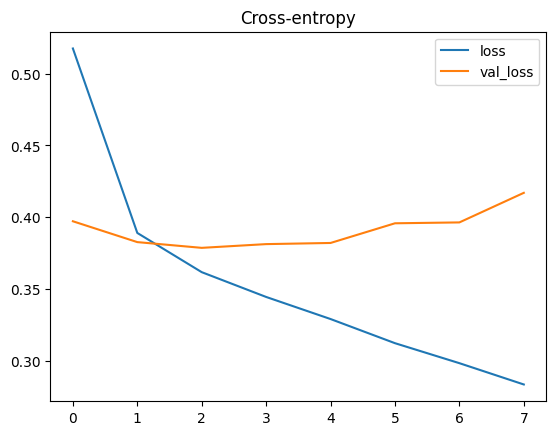

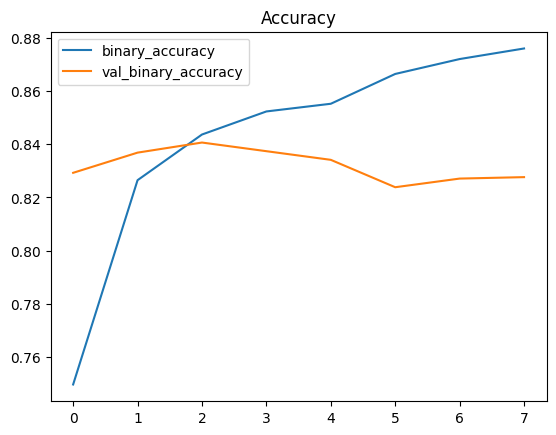

In [8]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [9]:
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                5040      
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,873
Trainable params: 5,873
Non-trainable params: 0
_________________________________________________________________


In [10]:
pred = np.array(nn.predict(X_valid))
pred = pd.Series(pred.flatten(), index=y_valid.index)
false_val = pred.loc[pred < 0.5] # Model predicts miss

a = np.array(false_val.index)
b = np.array(y_valid[y_valid < 0.5].index) # Actual miss
diff = np.setdiff1d(a, b) # Model misses - actual misses = Things the network thinks you will miss but you didn't miss
print(diff.shape)
pred.describe()

58/58 [==============================] - 0s 1ms/step
(125,)


count    1845.000000
mean        0.511650
std         0.378739
min         0.000558
25%         0.083608
50%         0.575679
75%         0.905537
max         0.993970
dtype: float64

In [11]:
novice.drop(['annId', 'urls', 'siteIds', 'animeScore', 'altAnswers', 'fromList', 'gameMode', 'selfAnswer', 'players'], axis=1).iloc[diff]

,name,artist,anime,songNumber,activePlayers,totalPlayers,type,difficulty,animeType,vintage,tags,genre,startSample,videoLength,correct
159,My Home Town,"Sora Amamiya, Rie Takahashi, Ai Kayano",{'english': 'KONOSUBA: God's Blessing on This ...,25,228,239,Ending 1,41.0,movie,Summer 2019,"[Demons, Magic, Parody, Satire, Male Protagoni...","[Action, Adventure, Comedy, Fantasy, Supernatu...",23.0,89.59,True
203,Polka de Taka no Tsume,FROGMAN to Red Chili Gasshou-dan,{'english': 'Himitsu Kessha Taka no Tsume NEO'...,24,218,227,Ending 4,25.3,TV,Spring 2012,"[Parody, Super Power]",[Comedy],0.0,28.30,True
305,ME!ME!ME!,TeddyLoid feat. daoko,"{'english': 'Japan Animator Expo', 'romaji': '...",36,225,238,Insert Song,30.9,ONA,Fall 2014,"[Magic, Military, Swordplay, Space, Satire, Go...","[Action, Ecchi, Fantasy, Mecha, Music, Superna...",197.0,327.47,True
311,LIGHTS,Aimi,{'english': 'How a Realist Hero Rebuilt the Ki...,42,226,239,Ending 1,23.6,TV,Winter 2022,"[Harem, Male Protagonist, Time Manipulation, P...","[Action, Adventure, Fantasy, Romance]",11.0,84.36,True
359,anemos,Anemoneria,"{'english': 'Wonder Egg Priority', 'romaji': '...",45,230,255,Insert Song,17.9,special,Spring 2021,"[Tragedy, Primarily Female Cast, Gore, Female ...","[Action, Drama, Fantasy, Mystery, Psychologica...",108.0,246.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7076,Niji,Masaki Suda,"{'english': 'Stand By Me Doraemon 2', 'romaji'...",27,57,58,Ending 1,21.3,movie,Fall 2020,"[Kids, Full CGI, Time Manipulation, Robots]","[Adventure, Comedy, Fantasy]",156.0,233.52,True
7102,Kaze wa Yokoku Naku Fuku,Walküre,{'english': 'Macross Delta Movie: Zettai LIVE!...,53,58,60,Insert Song,36.3,movie,Fall 2021,"[Military, Space, Tragedy, Idol, Robots, Musical]","[Action, Mecha, Music, Romance, Sci-Fi]",21.0,75.82,True
7136,Susume! Mujina Company,Neko Hacker feat. Rina Hidaka & Hisako Kanemot...,"{'english': 'Cute Executive Officer', 'romaji'...",2,53,53,Opening 1,19.0,ONA,Winter 2021,"[Cute Girls Doing Cute Things, Work, Surreal C...",[Comedy],5.0,89.21,True
7180,Kyun♥Kyun everyday,Haruko Aoki,"{'english': 'Rescue Me!', 'romaji': 'Rescue Me!'}",46,55,58,Ending 1,27.2,OVA,Spring 2013,"[Harem, Male Protagonist, Nudity]","[Comedy, Ecchi, Romance]",24.0,71.04,True


In [12]:
X_valid = pd.DataFrame(X_valid, columns=X.columns, index=X_valid_initial.index)
test_r = X_valid.loc[(X_valid['difficulty'] < -0.2) & (X_valid['difficulty'] > -0.4)].iloc[0].name
row = X_valid.loc[test_r]

In [13]:
explainer = shap.KernelExplainer(nn, X_valid)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], row)

Using 1845 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


KeyboardInterrupt: 

In [ ]:
novice.drop(['annId', 'urls', 'siteIds', 'animeScore', 'altAnswers', 'fromList', 'gameMode', 'selfAnswer', 'players', 'activePlayers', 'totalPlayers'], axis=1).iloc[row.name]

## XGBoost

In [ ]:
model = xgb.XGBRegressor(n_estimators=1000, eta=0.02, random_state=1, objective='binary:logistic')

In [ ]:
model.fit(X_train, y_train)

pred = np.array(model.predict(X_valid))
pred = pd.Series(pred.flatten(), index=y_valid.index)
false_val = pred.loc[pred < 0.5] # Model predicts miss

a = np.array(false_val.index)
b = np.array(y_valid[y_valid < 0.5].index) # Actual miss
diff = np.setdiff1d(a, b) # Model misses - actual misses = Things the network thinks you will miss but you didn't miss
print(diff.shape)
pred.describe()

In [ ]:
df = novice.drop(['annId', 'urls', 'siteIds', 'animeScore', 'altAnswers', 'fromList', 'gameMode', 'selfAnswer', 'players'], axis=1).iloc[diff]
df

In [6]:
expert['type_noNumber'] = expert['type'].str.split().str[0]
expert['name'].value_counts()

Natural               3
close to you          3
Adios DE Gundam       3
Kyun♥Kyun everyday    3
Yumemiru, Chikara     3
                     ..
Wataridori            1
Makoto Period         1
Beautiful Soldier     1
edge                  1
Kujira                1
Name: name, Length: 1968, dtype: int64